In [11]:
import os, sys
import pickle
import polars as pl

In [12]:
# Define el ID del experimento que quieres analizar
DATA_ID = 'simulation_1' 
N_REALIZATIONS = 100

project_path = os.path.abspath(os.path.join(os.getcwd(), '..')) # Subir un nivel
results_dir = os.path.join(project_path, 'results', 'experiment_2', DATA_ID)
filename = f'results_exp_2_{DATA_ID}.pkl'
results_path = os.path.join(results_dir, filename)

sys.path.append(project_path)

from src.experiments_utils import plot_experiment_2_results
#from config.config_experiment_2 import N_REALIZATIONS

In [13]:
# -------------------------------------------------------------------------
# CARGAR RESULTADOS
# -------------------------------------------------------------------------
if not os.path.exists(results_path):
    print("❌ Error: El archivo no existe. Revisa el DATA_ID o la ruta.")
else:
    with open(results_path, 'rb') as f:
        results = pickle.load(f)
    print(f"✅ Archivo cargado correctamente. Tipo de objeto: {type(results)}")
    print(f"📊 Número de realizaciones (seeds) capturadas: {len(results)}")

# -------------------------------------------------------------------------
# CONVERSIÓN A DATAFRAME  
# -------------------------------------------------------------------------
rows = []
for seed, metrics in results.items():   
    # Asumimos que todas las métricas tienen las mismas claves (frac_sample_sizes)
    frac_sample_sizes = metrics['ARI'].keys() 
    
    for frac in frac_sample_sizes:
        row = {
            'random_state': seed,
            'frac_sample_size': frac,
            'time': metrics['time'].get(frac),
            'adj_accuracy': metrics['adj_accuracy'].get(frac),
            'ARI': metrics['ARI'].get(frac)
        }
        rows.append(row)

df = pl.DataFrame(rows)

✅ Archivo cargado correctamente. Tipo de objeto: <class 'dict'>
📊 Número de realizaciones (seeds) capturadas: 100


In [14]:
df

random_state,frac_sample_size,time,adj_accuracy,ARI
i64,f64,f64,f64,f64
6863,0.0005,22.635688,0.645371,0.507339
6863,0.005,22.305419,0.876571,0.705125
6863,0.01,22.012666,0.877914,0.708651
6863,0.05,22.213204,0.878257,0.709512
6863,0.1,24.062816,0.874314,0.700746
…,…,…,…,…
30032,0.01,19.257468,0.885257,0.725138
30032,0.05,18.455559,0.875457,0.70317
30032,0.1,21.278211,0.8746,0.701298


In [15]:
df_avg = (
    df.group_by(['frac_sample_size'])
    .agg(pl.mean(['ARI', 'adj_accuracy', 'time']))
    .sort('frac_sample_size')
)

df_avg

frac_sample_size,ARI,adj_accuracy,time
f64,f64,f64,f64
0.0005,0.588522,0.786402,20.951821
0.005,0.703739,0.875934,20.716412
0.01,0.70509,0.876518,20.822553
0.05,0.707322,0.877413,20.996505
0.1,0.708787,0.87804,23.452654
0.2,0.710166,0.878665,35.897343
0.35,0.710354,0.878725,74.660429


In [16]:
# VISUALIZATION PARAMETERS 

best_row = df_avg.sort("adj_accuracy", descending=True).row(0, named=True)

best_frac = best_row["frac_sample_size"]
best_acc = best_row["adj_accuracy"]
best_ari = best_row["ARI"]
best_time = best_row["time"]

# Preparamos los datos para ejes X (convertidos a porcentaje) e Y
x_data_pct = df_avg["frac_sample_size"] * 100
y_acc = df_avg["adj_accuracy"]
y_ari = df_avg["ARI"]
y_time = df_avg["time"]

plot_filename = f'plot_results_exp_2_{DATA_ID}.png'
save_path = os.path.join(results_dir, plot_filename)

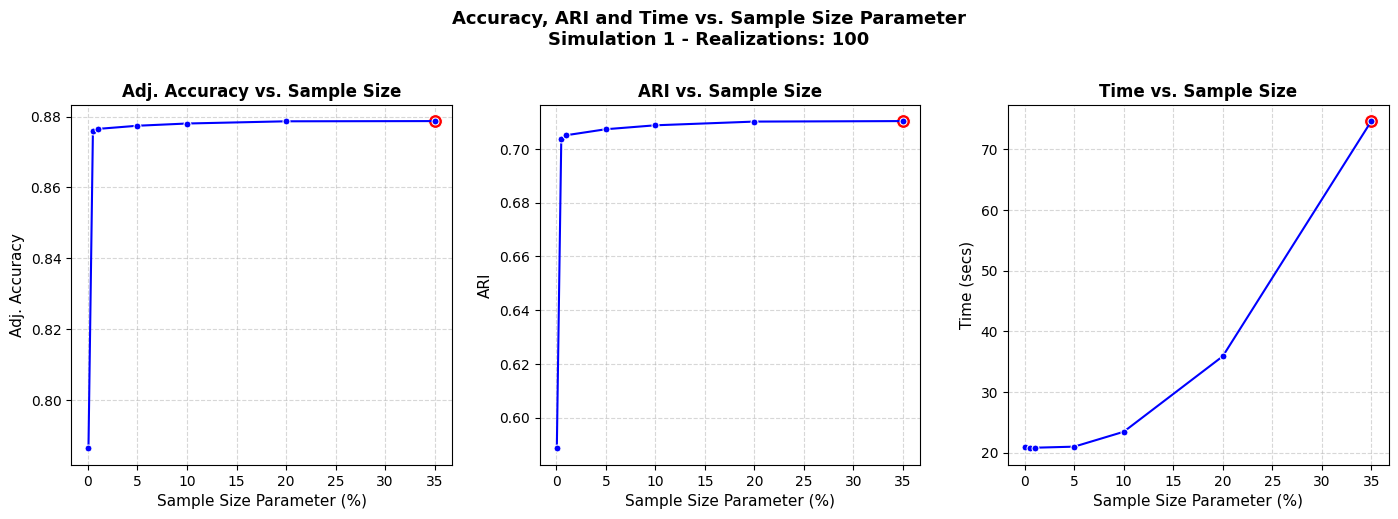

In [17]:
plot_experiment_2_results(
        best_frac, best_acc, best_ari, best_time, 
        x_data_pct, y_acc, y_ari, y_time,
        DATA_ID, N_REALIZATIONS, save_path
)